## <h1>Introduction to Data Science - Bank Marketing Project<h1>

    

Team Members:
    
Ophir Shurany ID: 304867716

Amit Shreiber ID: 200867174

<h2>1. Load Database<h2>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.close('all')
import time
start_time = time.time()

<h3>1.1.-1.3 Create and load dataframe<h3>

In [7]:
data = pd.read_csv("bank.csv",sep='|',encoding='utf8')
#drop duplicate data
df = data
df = df.drop_duplicates('Unnamed: 0',keep=False)
#drop #rows
df=df.drop('Unnamed: 0',axis=1)
df_copy_original=df #Keep original

<h2>2. Data Exploration<h2>

<h3>2.1. view first 5 rows in df<h3>

In [8]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,39.0,admin.,married,university.degree,no,no,no,cellular,jul,mon,...,3.0,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
2,51.0,management,married,university.degree,NaN,no,no,telephone,jun,fri,...,10.0,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,51.0,blue-collar,married,basic.4y,NaN,no,yes,telephone,jun,tue,...,1.0,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,yes
5,53.0,services,married,high.school,NaN,no,no,telephone,may,thu,...,2.0,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
6,40.0,blue-collar,married,basic.6y,no,no,no,cellular,may,tue,...,1.0,11,1,success,-1.8,92.893,-46.2,1.344,5099.1,no


<h3>2.2. Presenting all columns, number of rows and type<h3>

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35370 entries, 0 to 39895
Data columns (total 21 columns):
age               35239 non-null float64
job               35370 non-null object
marital           35303 non-null object
education         33880 non-null object
default           27970 non-null object
housing           34527 non-null object
loan              34527 non-null object
contact           35370 non-null object
month             35370 non-null object
day_of_week       35370 non-null object
duration          35370 non-null int64
campaign          34954 non-null float64
pdays             35370 non-null int64
previous          35370 non-null int64
poutcome          35370 non-null object
emp.var.rate      35370 non-null float64
cons.price.idx    35370 non-null float64
cons.conf.idx     35370 non-null float64
euribor3m         35370 non-null float64
nr.employed       35370 non-null float64
y                 35370 non-null object
dtypes: float64(7), int64(3), object(11)
memory

<h3>2.3. Feature statistics for numerical categories<h3>

In [10]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,35239.000000,35370.000000,34954.000000,35370.000000,35370.000000,35370.000000,35370.000000,35370.000000,35370.000000,35370.000000
mean,40.042879,257.985129,2.572209,963.598728,0.168335,0.097665,93.579768,-40.467928,3.640882,5167.701453
std,10.416313,258.531122,2.767796,184.121868,0.483834,1.564469,0.577052,4.613972,1.726877,71.725021
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.876000,-41.800000,4.857000,5191.000000
75%,47.000000,318.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Histograms for categorial features

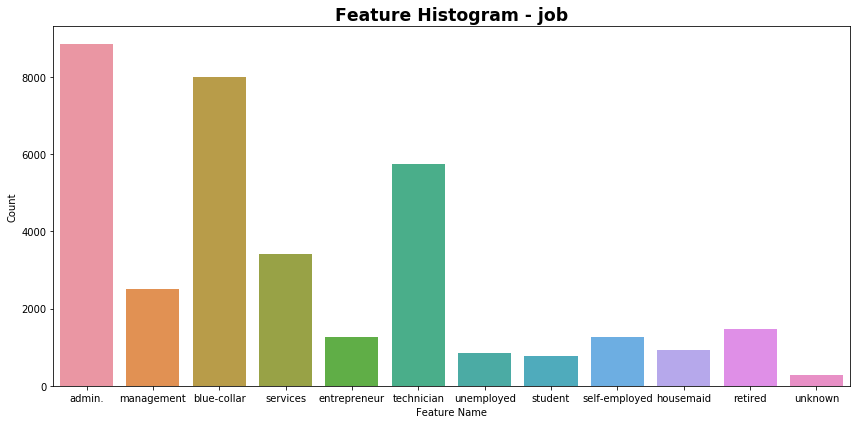

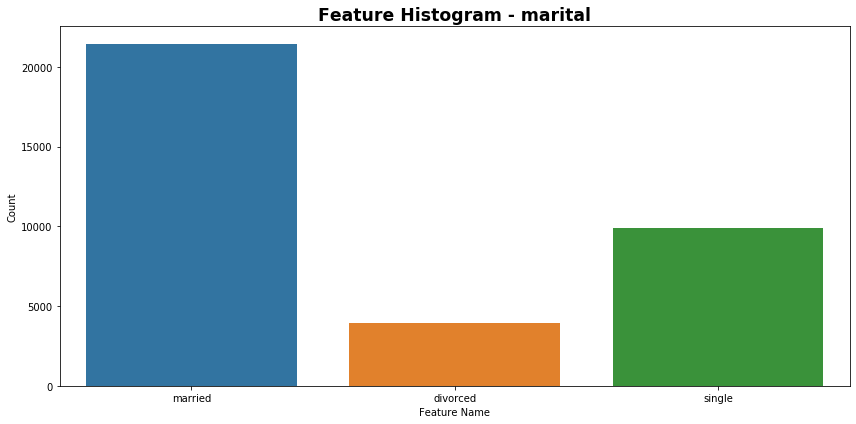

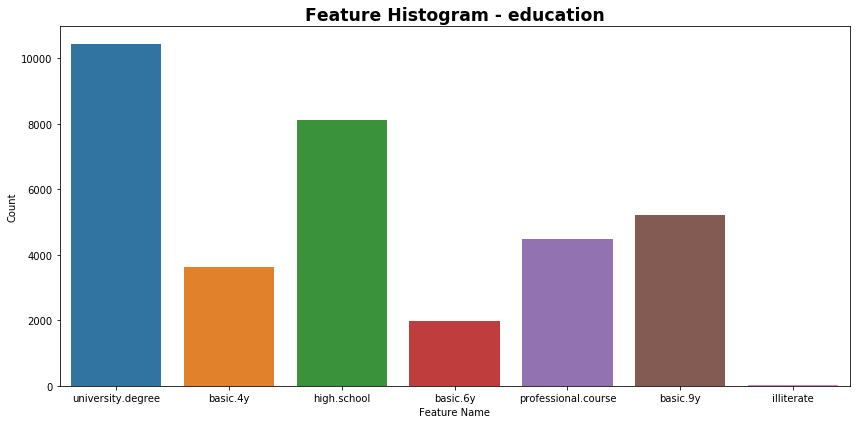

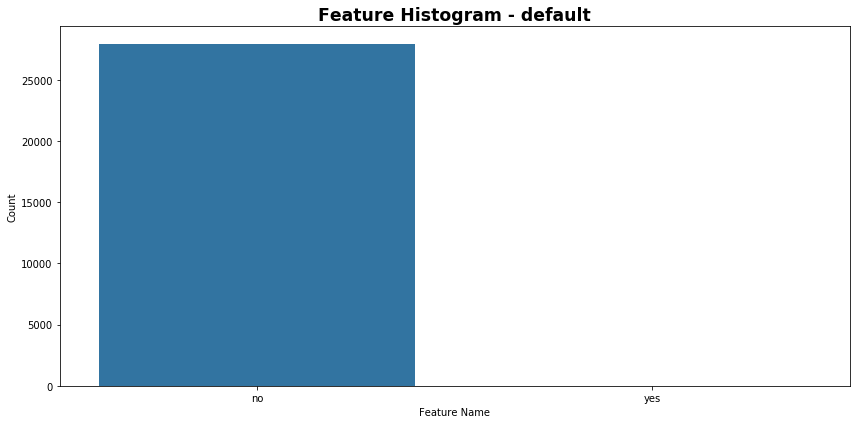

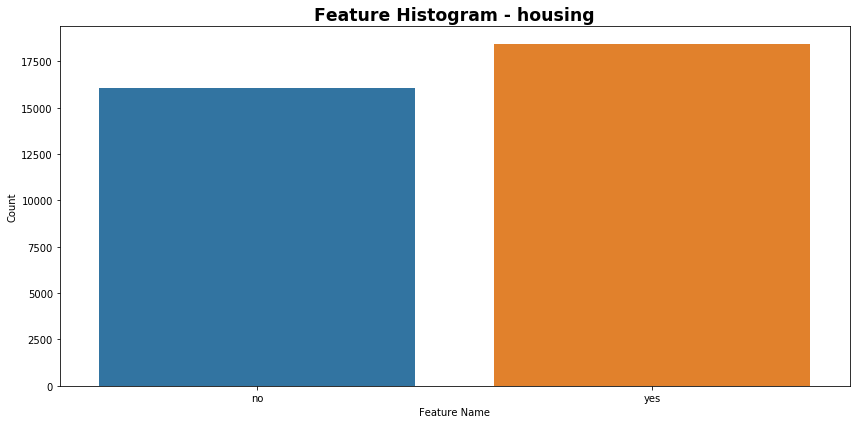

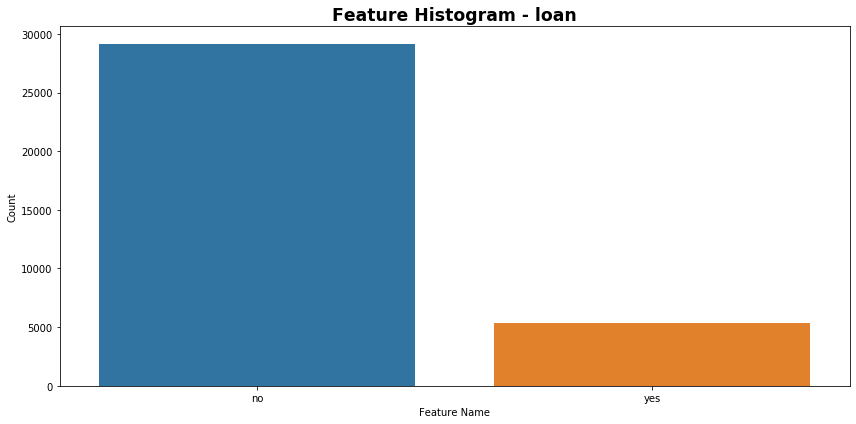

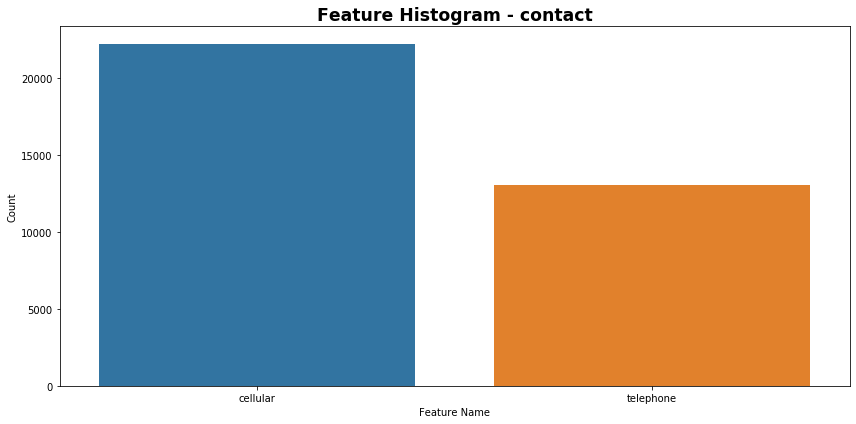

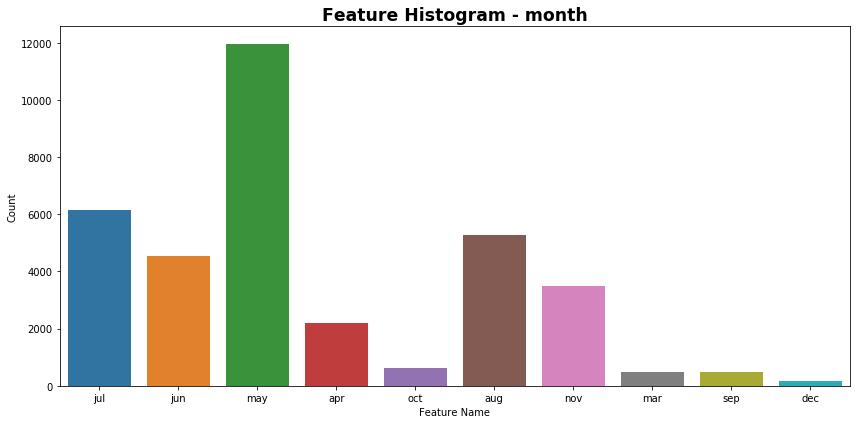

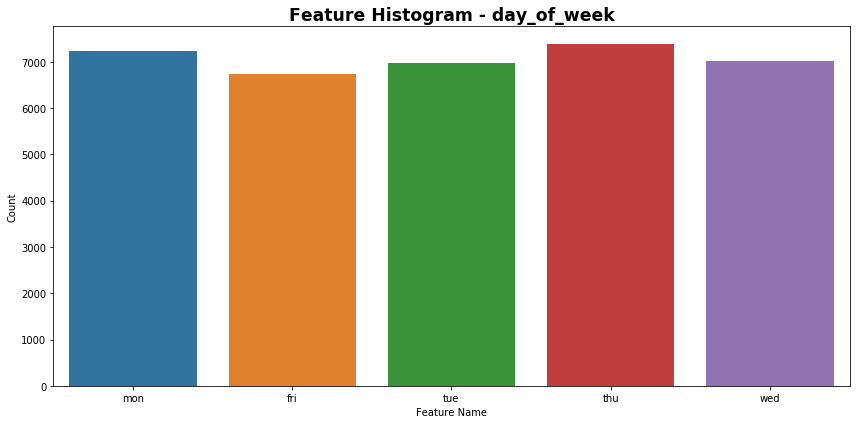

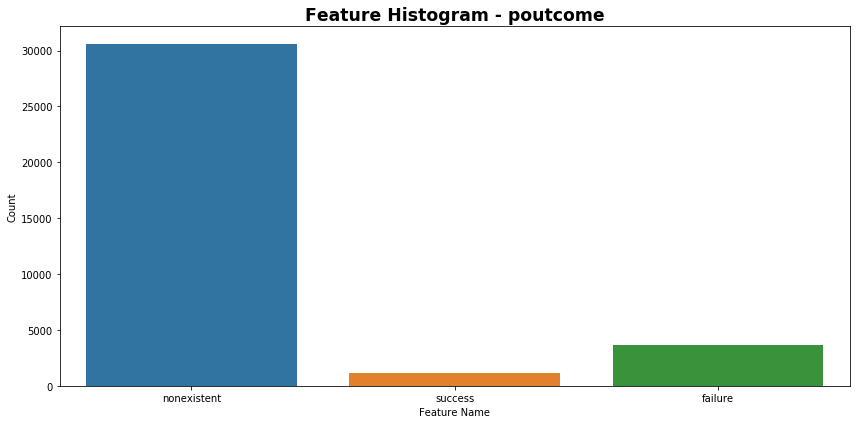

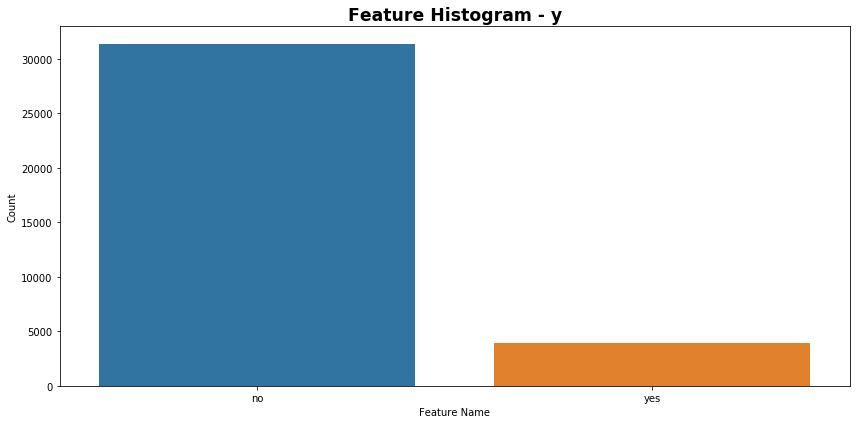

In [11]:
categorcial_variables =list(df.select_dtypes(include="object").columns)
for feature in categorcial_variables:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=feature,data=df)
    plt.title("Feature Histogram - " + feature,fontsize='xx-large', fontweight='bold')
    plt.ylabel("Count")
    plt.xlabel("Feature Name")
    plt.tight_layout()

Histograms for Numeric features

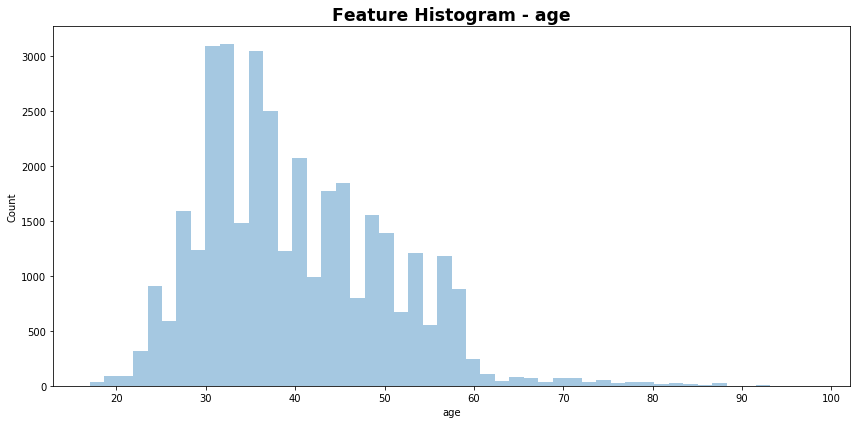

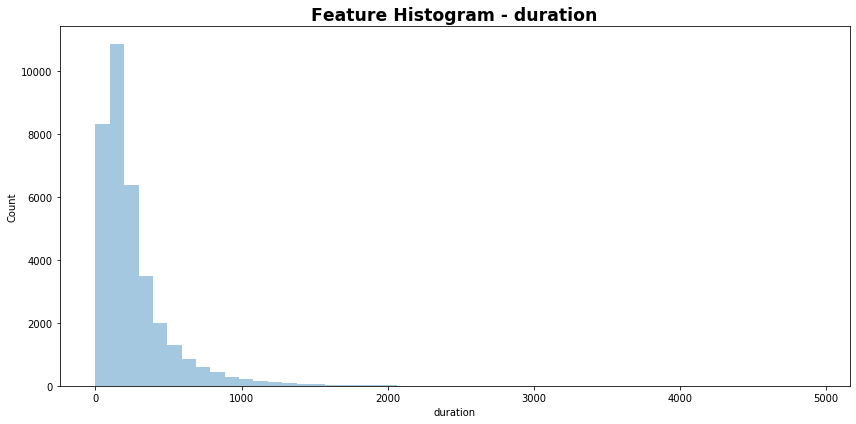

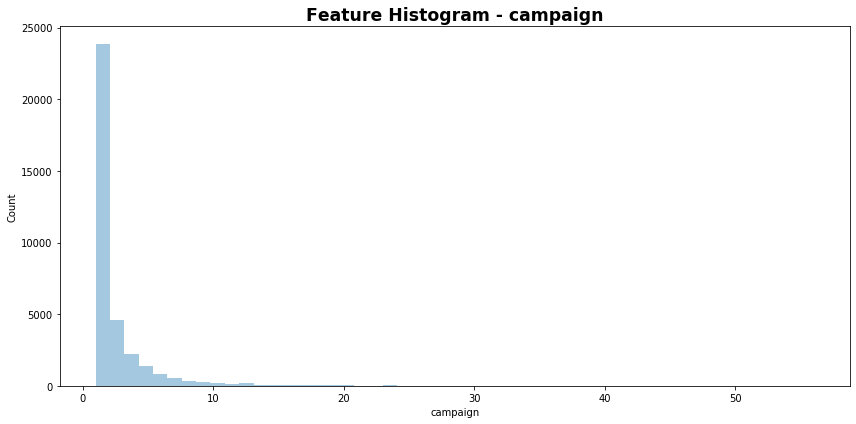

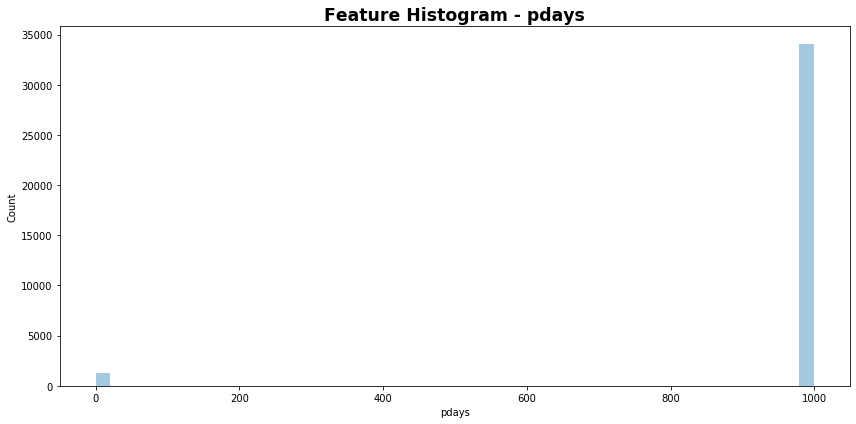

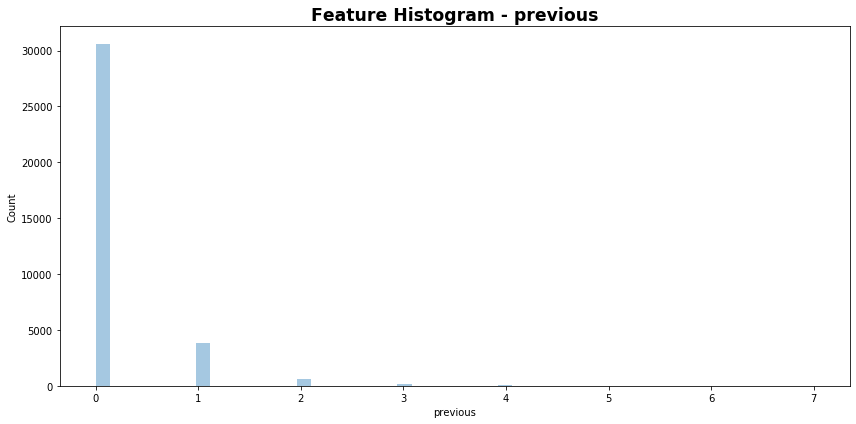

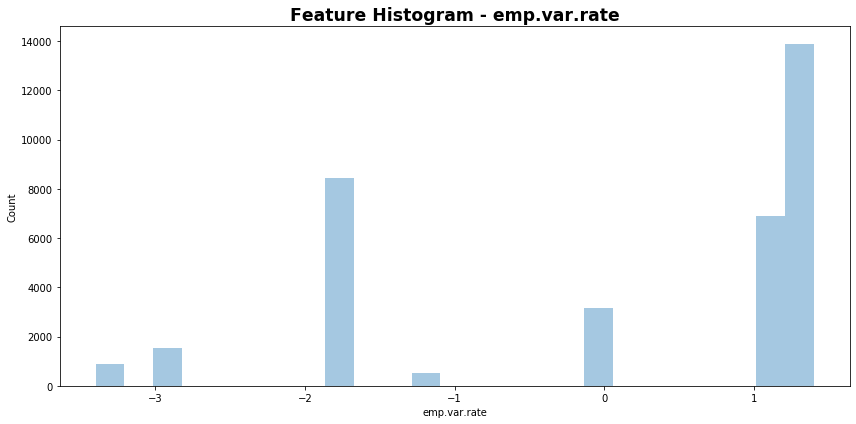

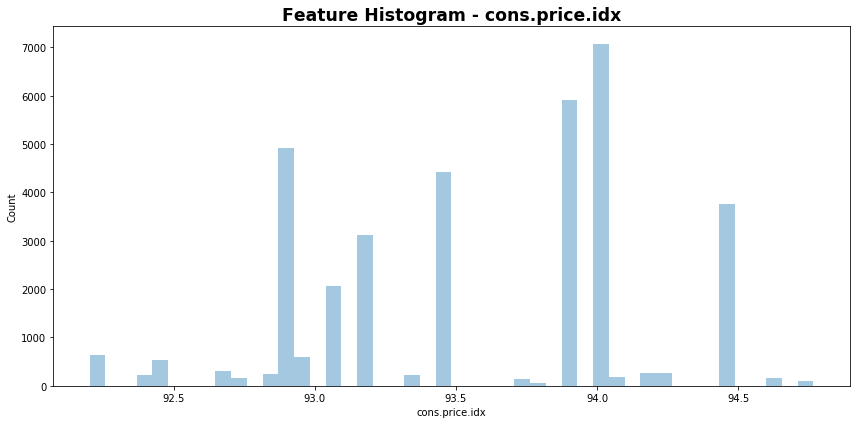

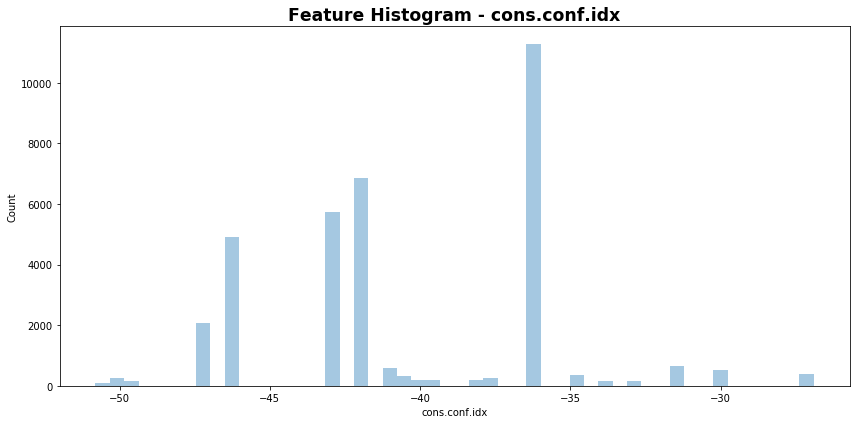

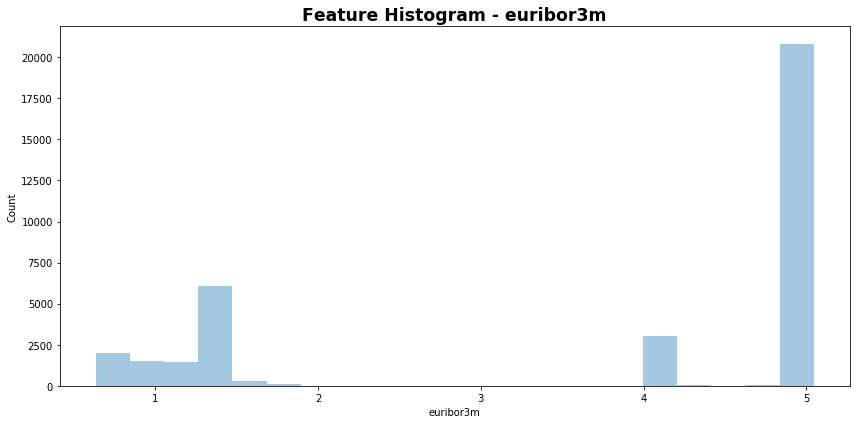

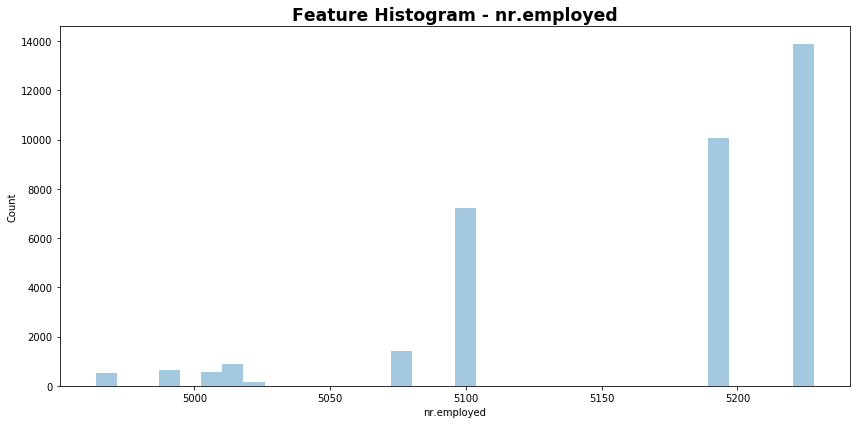

In [12]:
num_features = list(df.select_dtypes(exclude="object").columns)
for feature in num_features:
#devide for economic 
    plt.figure(figsize=(12, 6))
    sns.distplot(df[feature].dropna(),kde=False)
    plt.title("Feature Histogram - " + feature,fontsize='xx-large', fontweight='bold')
    plt.ylabel("Count")
    plt.xlabel(feature)
    plt.tight_layout()

<h3>2.4. Categorial manipulations:<h3>

<h4>2.4.1 change "yes" or "no" to 1 or 0<h4>

In [13]:
df['y'] = df.y.map(dict(yes=1, no=0))

<h4>2.4.2 Convert the month list to 4 binary quarters column <h4>

In [14]:
months=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'];
Q = [1,1,1,1,2,2,2,3,3,3,4,4,4];month_dic=dict(zip(months,Q))
df['month']=df.month.replace(month_dic)
df=pd.get_dummies(df, columns=['month'],prefix='Q')

<h4>2.4.3. convert categorial features to numeric and drop the number of variables<h4>

In [15]:
#education
df['education']=df.education.replace(['basic.6y','basic.4y', 'basic.9y'], 'basic')
#job
df.job.replace(['admin.', 'management'], 'administration_management', inplace=True)
df.loc[(df['age'] > 60 ) & (df['job'] == 'administration_management' ) , 'job'] = 'retired'
df.job.replace(['retired', 'unemployed'], 'no_active_income', inplace=True)
df.job.replace('housemaid', 'services',inplace=True)
df['job']=df.job.replace('entrepreneur', 'self-employed')
# Convert other Series from yes or no to binary
df['housing'] = df.housing.map(dict(yes=1, no=0));
df['loan'] = df.loan.map(dict(yes=1, no=0));
df=df.rename(columns = {'contact':'contact_by_cellular'})
df['contact_by_cellular'] = df.contact_by_cellular.map(dict(cellular = 1, telephone = 0))

### <h2>3. Missing Values<h2>

In [16]:
print("3.1. Total NaN rows = " + str(sum(df.isna().sum())))

3.1. Total NaN rows = 11190


 Present NaN % in each feature. 

In [17]:
(100*df.isna().sum()/df.shape[0]).round(1)

age                     0.4
job                     0.0
marital                 0.2
education               4.2
default                20.9
housing                 2.4
loan                    2.4
contact_by_cellular     0.0
day_of_week             0.0
duration                0.0
campaign                1.2
pdays                   0.0
previous                0.0
poutcome                0.0
emp.var.rate            0.0
cons.price.idx          0.0
cons.conf.idx           0.0
euribor3m               0.0
nr.employed             0.0
y                       0.0
Q_1                     0.0
Q_2                     0.0
Q_3                     0.0
Q_4                     0.0
dtype: float64

In [18]:
#we need to see how values are distributed:
#first, we convert unknown values from NaN so they will be countable as unknown:
df['default'] = df.default.replace(np.nan,'unknown',regex=True)
#default
pd.crosstab(df['y'],df['default'],dropna=True).apply(lambda r: r/r.sum(), axis=1).round(4)
#most of No are at default, so we cant really learn from it. then, it will be deleted
df=df.drop("default",axis=1)
#loan
df['loan'] = df.loan.replace(np.nan,'unknown',regex=True)
pd.crosstab(df['y'],df['loan']).apply(lambda r: r/r.sum(), axis=1).round(2)
df['loan'] = df['loan'].replace('unknown',0)
#housing
df['housing'] = df.housing.replace(np.nan,'unknown',regex=True)
pd.crosstab(df['y'],df['housing']).apply(lambda r: r/r.sum(), axis=1).round(2)
#values distribute practicly evenly, therefore we can delete uknowns:
df = df[df.housing != "unknown"]

 We think that ‘job’ is influenced 
 by the ‘education’ of a person. because that, 
 we can infer ‘job’ based on the education of the person.
 Moreover, since we are just filling the missing values,
 we are not much concerned about the causal inference.
 We can use the job to predict education.

to infer the missing values in 'job' and 'education', we make use of the cross-tabulation between 'job' and 'education'.


In [19]:
df['education'] = df.education.replace(np.nan,'unknown',regex=True)
df['job'] = df.job.replace(np.nan,'unknown',regex=True)
pd.crosstab(df['job'], df['education'], rownames=['job'], colnames=['education'],margins=True)

education,basic,high.school,illiterate,professional.course,university.degree,unknown,All
job,,,,,,,
administration_management,896,2974,1,379,6519,309,11078
blue-collar,6214,746,8,378,84,371,7801
no_active_income,958,446,3,324,488,101,2320
self-employed,646,298,3,254,1185,80,2466
services,1171,2387,1,242,249,170,4220
student,119,306,0,36,143,139,743
technician,443,731,0,2764,1510,176,5624
unknown,89,30,0,10,37,109,275
All,10536,7918,16,4387,10215,1455,34527


While imputing the values for job and education, we followed the fact that
the correlations should make real world sense. 

In [20]:
#education 
#for education it makes sense to use ranking
education_dic={'illiterate': 0,'basic' : 1,'high.school' : 2,'professional.course' : 3,'university.degree' : 4}
df['education']=df.education.replace(education_dic)

By the cross table above we can infer the following:

In [21]:
#Most customers with "basic" education work as "blue-collar"
df.loc[(df['job']=='unknown') & (df['education']==1), 'job'] = 'blue-collar'
df.loc[(df['education']=='unknown') & (df['job']=='blue-collar'), 'education'] = 1
#Most customers in "services" have a "high.school"  degree
df.loc[(df['education']=='unknown') & (df['job']=='services'), 'education'] = 2
df.loc[(df['job']=='unknown') & (df['education']==2), 'job'] = 'services'
#Most customers with "professional.course education work as "technician"
df.loc[(df['job']=='unknown') & (df['education']==3), 'job'] = 'technician'
df.loc[(df['education']=='unknown') & (df['job']=='technician'), 'education'] = 3
#Most customers in "administration_management" have a "university.degree"  
df.loc[(df['education']=='unknown') & (df['job']=='administration_management'), 'education'] = 4
df.loc[(df['job']=='unknown') & (df['education']=='administration_management'), 'job'] = 'administration_management'

In [22]:
pd.crosstab(df['job'], df['education'], rownames=['job'], colnames=['education'],margins=True)

education,0,1,2,3,4,unknown,All
job,,,,,,,
administration_management,1,896,2974,379,6828,0,11078
blue-collar,8,6674,746,378,84,0,7890
no_active_income,3,958,446,324,488,101,2320
self-employed,3,646,298,254,1185,80,2466
services,1,1171,2587,242,249,0,4250
student,0,119,306,36,143,139,743
technician,0,443,731,2950,1510,0,5634
unknown,0,0,0,0,37,109,146
All,16,10907,8088,4563,10524,429,34527


Text(0, 0.5, 'Count')

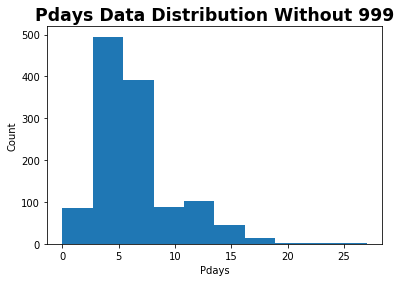

In [23]:
#Impute by mean value for age & campaign
#age
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
df["age"] = imputer.fit_transform(df[['age']])
#campaign
df['campaign'] = imputer.fit_transform(df[['campaign']])
# Examine the missing values in 'pdays'
plt.figure()
plt.hist(df.loc[df.pdays != 999, 'pdays'])
plt.title("Pdays Data Distribution Without 999", fontsize='xx-large', fontweight='bold')
plt.xlabel("Pdays")
plt.ylabel("Count")

two varibale are connected - pdays and poutcome. Lets check their connection and how many NaN we have-

In [24]:
pd.crosstab(df['pdays'],df['poutcome'],dropna=False,margins=True)

poutcome,failure,nonexistent,success,All
pdays,,,,
0,0,0,14,14
1,0,0,20,20
2,0,0,51,51
3,3,0,356,359
4,2,0,96,98
5,4,0,34,38
6,22,0,309,331
7,13,0,34,47
8,4,0,10,14


As we can see from the above table, the majority of the values for 'pdays'
are missing. The majority of these missing values occur when the 'poutcome'
is 'non-existent'. This means that the majority of the values in 'pdays'
are missing because the customer was never contacted before. To deal with 
this variable, we removed the numerical variable 'pdays' and replaced it
with categorical variables with following categories: p_days_missing, 
pdays_less_5, pdays_bet_5_15, and pdays_greater_15.

Add new categorical variables to our dataframe.

In [25]:
df['pdays_missing'] = 0
df['pdays_less_5'] = 0
df['pdays_greater_15'] = 0
df['pdays_bet_5_15'] = 0
df['pdays_missing'][df['pdays']==999] = 1
df['pdays_less_5'][df['pdays']<5] = 1
df['pdays_greater_15'][(df['pdays']>15) & (df['pdays']<999)] = 1
df['pdays_bet_5_15'][(df['pdays']>=5)&(df['pdays']<=15)]= 1
df= df.drop(['pdays','pdays_less_5'], axis=1)

Since we have many categorical variables, dummy variables needs to be created for those vaiables.

In [26]:
#convert categorical variables to dummy
df = pd.get_dummies(df , columns = ['job', 'marital' ,'day_of_week', 'poutcome'])

In [27]:
df = df[df != "unknown"]
print("we remove all other NaNs")
df = df.dropna()

we remove all other NaNs


In [28]:
print("Number of deleted rows = " + str(df_copy_original.shape[0]-df.shape[0]))

Number of deleted rows = 1272


In [29]:
print("only "+ str(round(100*(df_copy_original.shape[0]-df.shape[0])/df.shape[0],1))+" %")

only 3.7 %


In [30]:
print("Finally, the total NaN rows = " + str(sum(df.isna().sum())))

Finally, the total NaN rows = 0


#### Q4

Delete Q4 in order to avoid dummy variable trap.

#### duration

The variable “duration” will need to be dropped before we start building a predictive model
because it highly affects the output target (e.g., if duration=0 then y=”no”). 

Yet, the duration is not known before a call is performed.

In [31]:
df=df.drop(["duration","Q_4"],axis=1)

<h3>2.5. correlation heat map<h2>

Text(0.5, 1, 'Correlation Matrix')

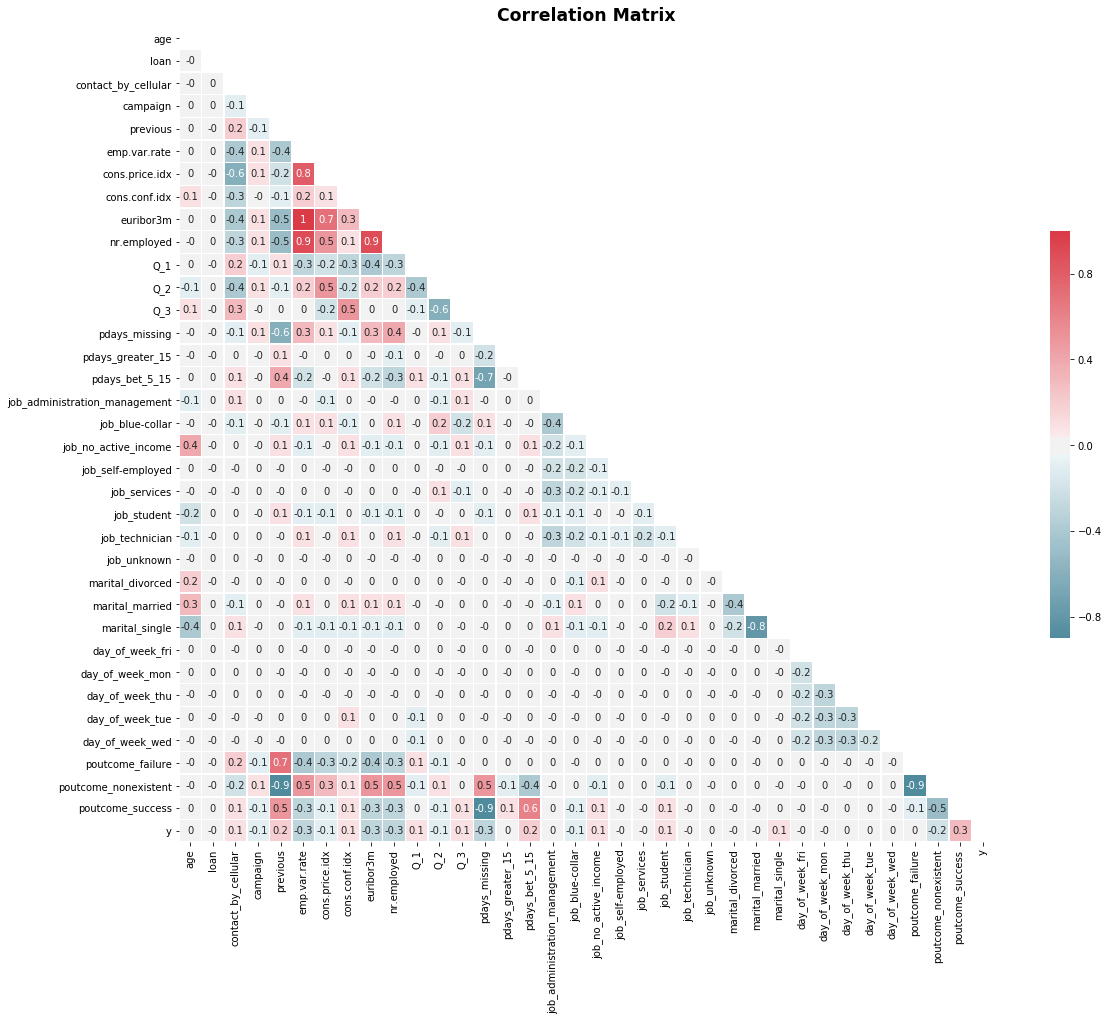

In [32]:
#Put the target as last feature
y=df.y
df=df.drop("y",axis=1)
df["y"]=y
cor = df.corr().round(1)
mask = np.zeros_like(cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(20, 15))
heatmap=sns.heatmap(cor,mask=mask,annot=True,annot_kws={"size": 10},
                    center=0,cmap=cmap,square=True, linewidths=.5,
                    cbar_kws={"shrink": .5},yticklabels=1,xticklabels=1)
plt.title("Correlation Matrix", fontsize='xx-large', fontweight='bold')

we can see from heatmap that the highest correlate features (abs(0.9) and above)
the features the economic features: **["nr.employes"-"emp.var.rate"],["cons.price.idx"-"emp.var.rate"]
["euribor3m"-"emp.var.rate"],["nr.employes"-"euribor3m"],["poutcome_nonexsist-previous"],["poutcome_nonexsist-poutcome_failure"]**
nr.employed and emp.var.rate are  *highly  corelated* and also nr.employed
and euribor3m are highly  corelated.  
because that we will remove emp.var.rate and euribor3m

In [33]:
#Delete the features above at 1 command
df=df.drop(["euribor3m","emp.var.rate","poutcome_nonexistent","marital_single","pdays_missing"],axis=1)

In [34]:
df_copy_feature_filtered=df.copy()

Now we want to see the updated correlation matrix

Text(0.5, 1, 'Updated Correlation Matrix')

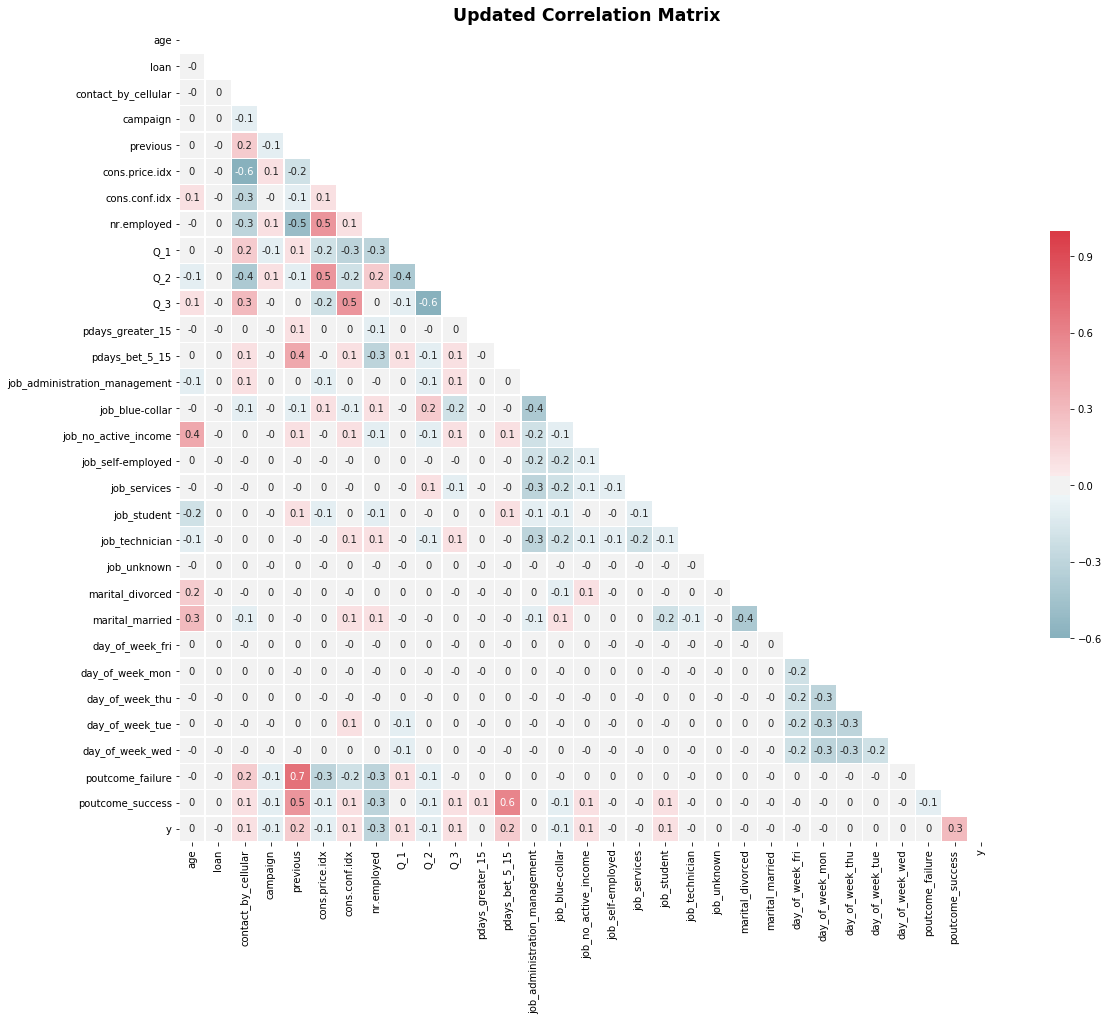

In [35]:
cor = df.corr().round(1)
mask = np.zeros_like(cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(20, 15))
heatmap=sns.heatmap(cor,mask=mask,annot=True,annot_kws={"size": 10},
                    center=0,cmap=cmap,square=True, linewidths=.5,
                    cbar_kws={"shrink": .5},yticklabels=1,xticklabels=1)
plt.title("Updated Correlation Matrix", fontsize='xx-large', fontweight='bold')

<h2>4. Data Normalization<h2>

<h3>4.1. Box Plot <h2>

**Outliers: Outliers are defined as 1.5 x Q3 value (75th percentile).**

In [36]:
feature_lst=["cons.price.idx","nr.employed","cons.conf.idx","age","campaign","previous"]
df_with_outliers=df.copy()

**cons.price.idx**

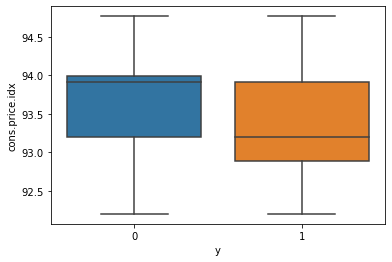

In [37]:
sns.boxplot(x='y', y="cons.price.idx", data=df_with_outliers)

There are no outliers for this feature.

**nr.employed**

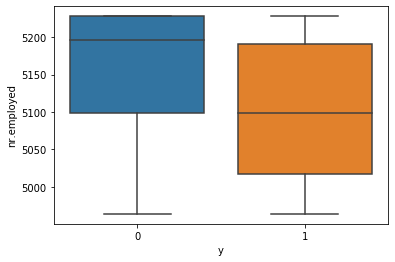

In [38]:
sns.boxplot(x='y', y="nr.employed", data=df_with_outliers)

There are no outliers for this feature.

**cons.conf.idx**

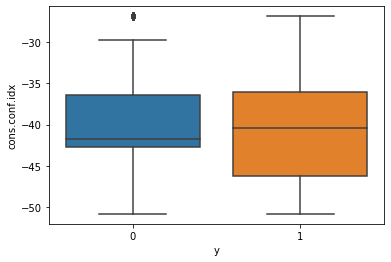

In [39]:
sns.boxplot(x='y', y="cons.conf.idx", data=df_with_outliers)

There are some unusual results in the target variable "no", but these do not significantly exceed the upper limit. 

Then, they fit the upper bound of the target variable "yes". 

Therefore, we chose to leave it.

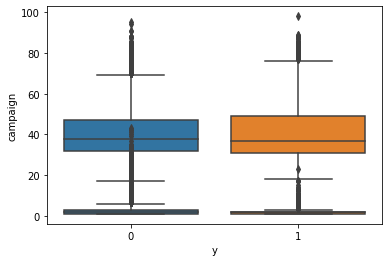

In [40]:
sns.boxplot(x='y', y="age", data=df_with_outliers)
sns.boxplot(x='y', y="campaign", data=df_with_outliers)

We have outliers as max('age') and max('campaign') > 1.5Q3('age') and >1.5Q3('campaign') respectively.

But we also see that the value of these outliers are not so unrealistic (max('age')=98 and max('campaign')=56).

Hence, we need not remove them since the prediction model should represent the real world. 

This improves the generalizability of the model and makes it robust for real world situations. 

The outliers, therefore, are not removed.

**"previous"**

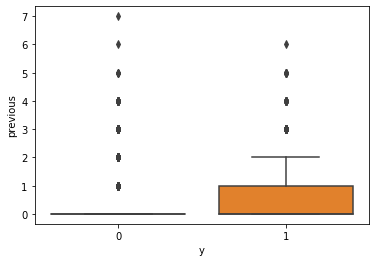

In [41]:
sns.boxplot(x='y', y="previous", data=df_with_outliers)

This variable has many unusual results, from the database, The unusual results belong to many calls made to a customer and therefore the outlierresults are much higher.

We decided to sift the top results that exceed 3 times the upper limit, leaving the other results less than the top limit.
we will do it at 5.3.

In [42]:
df_outliers=df_with_outliers[["previous"]]

<h3>4.2. Normalize features <h2>

In [43]:
from sklearn.preprocessing import MinMaxScaler   
numeric_df = df.select_dtypes(exclude="object")
scaler = MinMaxScaler(feature_range = (0,1))
normalized_df_data =scaler.fit_transform(numeric_df.values)
df_scaled=pd.DataFrame(normalized_df_data,columns=numeric_df.columns)

In [44]:
df_scaled

,age,loan,contact_by_cellular,campaign,previous,cons.price.idx,cons.conf.idx,nr.employed,Q_1,Q_2,...,marital_divorced,marital_married,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_success,y
0,0.271605,0.0,1.0,0.047619,0.000000,0.669135,0.338912,1.000000,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.419753,0.0,0.0,0.214286,0.000000,0.882307,0.376569,1.000000,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.419753,1.0,0.0,0.000000,0.000000,0.882307,0.376569,1.000000,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.444444,0.0,0.0,0.023810,0.000000,0.698753,0.602510,0.859735,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.283951,0.0,1.0,0.000000,0.142857,0.269680,0.192469,0.512287,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34093,0.518519,0.0,1.0,0.023810,0.142857,0.000000,0.811715,0.425709,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
34094,0.407407,0.0,0.0,0.023810,0.000000,0.882307,0.376569,1.000000,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34095,0.358025,0.0,0.0,0.023810,0.000000,0.389322,0.368201,0.877883,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
34096,0.333333,0.0,0.0,0.000000,0.000000,0.882307,0.376569,1.000000,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<h2>5. Outlier Detection <h2>

<h3>5.1. Clustrering by DBSCAN <h3>

*The optimal value for epsilon will be found at the point of maximum curvature.*

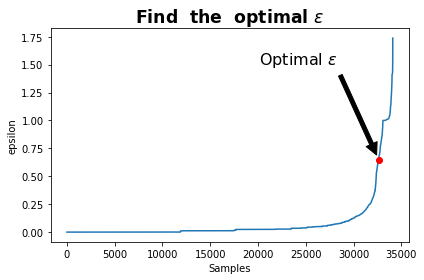

In [45]:
from sklearn.neighbors import NearestNeighbors
y_scaled_DB=pd.DataFrame(df_scaled.y)
data_scaled_DB=df_scaled.drop("y",axis=1)
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_scaled_DB)
distances, indices = nbrs.kneighbors(data_scaled_DB)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.title("Find  the  optimal "+r'$  \varepsilon$',fontsize='xx-large', fontweight='bold')
plt.ylabel("epsilon")
plt.xlabel("Samples")
plt.plot([32621], [0.65], 'ro')
plt.annotate('Optimal '+r'$\varepsilon$', (32621,0.65),
            xytext=(0.8, 0.9), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=16,
            horizontalalignment='right', verticalalignment='top')
plt.tight_layout()

eps = the best epsilon is at the "elbow" of NearestNeighbors graph

In [46]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.65,min_samples=5).fit(data_scaled_DB)
labels=db.labels_
clusterNum=len(set(labels))
print("number of clusters is "+str(clusterNum))
noise=np.count_nonzero(labels == -1)
noise_percentage=round(100*noise/data_scaled_DB.shape[0],0)
print("Number of outliers is "+str(noise)+ ", Noise accounts for "+str(noise_percentage)+"%  of the total dataset" )

number of clusters is 909
Number of outliers is 3843, Noise accounts for 11.0%  of the total dataset


In [47]:
data_scaled_DB["cluster_Db"]=labels
y_scaled_DB["cluster_Db"]=labels
data_scaled_DB = data_scaled_DB[data_scaled_DB.cluster_Db != -1]
y_scaled_DB = y_scaled_DB[y_scaled_DB.cluster_Db != -1]
data_scaled_DB=data_scaled_DB.drop("cluster_Db",axis=1)
y_scaled_DB=y_scaled_DB.drop("cluster_Db",axis=1)
data_scaled_DB["y"]=y_scaled_DB

<h3>5.2. Multiple Clustrers by DBSCAN <h3>

We found out that the best epsilon is just above the "elbow" - not that much noisy (about 15%) but lots of clusters that can define us different groups with different features.
**Lots of clusters means low number of noise, therefore low number of outliers.**

<h3>5.3. Another method to remove outliers - LOF <h3>

In [48]:
from scipy import stats
z = np.abs(stats.zscore(df_outliers))
#define a threshold to identify an outlier
threshold = 3
df_outliers=df_outliers[(z < threshold).all(axis=1)]
Num_outliers_2nd=df_with_outliers.shape[0]-df_outliers.shape[0]
print("outliers by each feature boxplot: "+str(Num_outliers_2nd))
from sklearn.neighbors import LocalOutlierFactor
# fit the model for outlier detection (default)
n_outliers = Num_outliers_2nd
ground_truth = np.ones(len(df_scaled), dtype=int)
ground_truth[-n_outliers:] = -1
LOF = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = LOF.fit_predict(df_scaled)
n_errors = (y_pred != ground_truth).sum()
X_scores = LOF.negative_outlier_factor_
LOF_outliers=np.count_nonzero(y_pred == -1)
LOF_outliers_percentage=round(100*np.count_nonzero(y_pred == -1)/df_scaled.shape[0],0)
print("Number of outliers by LOF is "+str(LOF_outliers)+ ", Noise accounts for "+str(LOF_outliers_percentage)+"%  of the total dataset" )

outliers by each feature boxplot: 814
Number of outliers by LOF is 3410, Noise accounts for 10.0%  of the total dataset


we can learn that local outliers (from each feature) does not predict the total outliers of the whole dataset by the combination of features.
That is why we have more outliers by LOF **and** DBSCAN than that shown in the boxplots above.

<h2>6. Predictive Models <h2>

Each classifier has many hyperparameters. We chose specific hyperparameters by there performance influence and running time.
We will show each model best parameters.

In [49]:
#%% 6. Predictive Models
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
from sklearn.utils import resample
kfold = model_selection.KFold(n_splits=3)
y=data_scaled_DB.y
X=data_scaled_DB.drop("y",axis=1)
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=0) #80/20 split

Data is imbalanced, therefore we used Upsampling.

In [50]:
y_train_no_yes=y_train.value_counts()
df_majority = data_scaled_DB[data_scaled_DB.y==0]
df_minority = data_scaled_DB[data_scaled_DB.y==1]
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=int(y_train_no_yes[0]),    # take a bunch from majority class
                                 random_state=123) # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled.y.value_counts()
y_upsample=df_upsampled.y
X_upsample=df_upsampled.drop("y",axis=1)
x_train_up, x_test_up, y_train_up, y_test_up = model_selection.train_test_split(X_upsample, y_upsample, test_size=0.2, random_state=0) #80/20 split
x_train=x_train_up
y_train= y_train_up

<h3>6.1. Logistic Regression <h3>

{'multi_class': ['auto', 'ovr', 'multinomial'],
 'penalty': ['l1', 'l2'],
 'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   15.6s finished


best hyperparameters for Logistic Regression are:
{'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}

              precision    recall  f1-score   support

          no       0.95      0.82      0.88      5533
         yes       0.23      0.55      0.32       518

    accuracy                           0.80      6051
   macro avg       0.59      0.69      0.60      6051
weighted avg       0.89      0.80      0.83      6051



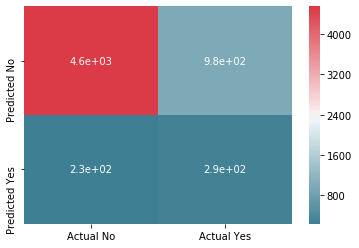

In [51]:
from sklearn.linear_model import LogisticRegression 
Log_Reg=LogisticRegression() 
solver = ['lbfgs', 'newton-cg',"liblinear","sag","saga"] 
multi_class = ['auto', 'ovr',"multinomial"] 
# Create the random grid 
random_grid = {'solver': solver,
               "penalty":["l1","l2"],
               'multi_class': multi_class} 
pprint(random_grid) 
# search across 100 different combinations, and use all available cores 
Log_Reg_random = RandomizedSearchCV(estimator = Log_Reg, 
                               param_distributions = random_grid, 
                               n_iter = 20, cv = kfold, verbose=2, 
                               random_state=42, n_jobs = -1) 
Log_Reg_random.fit(x_train, y_train) 
print("best hyperparameters for Logistic Regression are:")
pprint(Log_Reg_random.best_params_)
print("") 
Log_Reg_best_random = Log_Reg_random.best_estimator_ 
prediction_Log_Reg = Log_Reg_best_random.predict(x_test) 
CM_LR=confusion_matrix(y_test, prediction_Log_Reg)
df_cm = pd.DataFrame(CM_LR, index = ["Predicted No","Predicted Yes"],
                  columns = ["Actual No","Actual Yes"])
print(classification_report(y_test, prediction_Log_Reg,target_names=["no","yes"]))
plt.figure()
sns.heatmap(df_cm,cmap=cmap, annot=True)
#AUC 
probsLR = Log_Reg_random.predict_proba(x_test) 
predsLR = probsLR[:,1] 
fprLR, tprLR, thresholdLR = metrics.roc_curve(y_test, predsLR) 
roc_aucLR = metrics.auc(fprLR, tprLR)

<h3>6.2. ADABOOST <h3>

{'algorithm': ['SAMME', 'SAMME.R'],
 'base_estimator': [DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'),
                    DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')],
 'learning_rate': [0.098, 1, 1.02],
 'n_estimators': [50, 100]}
Fitting 3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.1min finished


best hyperparameters for ADABOOST are:
{'algorithm': 'SAMME.R',
 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'),
 'learning_rate': 1.02,
 'n_estimators': 100}

              precision    recall  f1-score   support

          no       0.95      0.88      0.92      5533
         yes       0.30      0.53      0.38       518

    accuracy                           0.85      6051
   macro avg       0.63      0.71      0.65      6051
weighted avg       0.90      0.85      0.87      6051



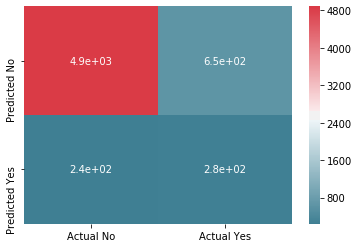

In [52]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ADA = AdaBoostClassifier()
# Create the random grid
random_grid = {'n_estimators': [50,100],
               "learning_rate":[0.098,1,1.02],
               "base_estimator":[DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2)],
              "algorithm":["SAMME", "SAMME.R"]}
pprint(random_grid)
# search across 100 different combinations, and use all available cores
ADA_random = RandomizedSearchCV(estimator = ADA, 
                               param_distributions = random_grid, 
                               n_iter = 20, cv = kfold, verbose=2, 
                               random_state=42, n_jobs = -1) 
ADA_random.fit(x_train, y_train)
print("best hyperparameters for ADABOOST are:")
pprint(ADA_random.best_params_)
print("")
ADA_best_random = ADA_random.best_estimator_
predictions_ADA = ADA_best_random.predict(x_test)
CM_ADA=confusion_matrix(y_test, predictions_ADA)
df_cm = pd.DataFrame(CM_ADA, index = ["Predicted No","Predicted Yes"],
                  columns = ["Actual No","Actual Yes"])
print(classification_report(y_test, predictions_ADA,target_names=["no","yes"]))
plt.figure()
sns.heatmap(df_cm,cmap=cmap, annot=True)
#AUC
probs_ADA = ADA_random.predict_proba(x_test)
preds_ADA = probs_ADA[:,1]
fprADA, tprADA,thresholdADA = metrics.roc_curve(y_test, preds_ADA)
roc_aucADA = metrics.auc(fprADA, tprADA)

<h3>6.3. Gradient Boosting <h3>

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.3min finished


best hyperparameters for Gradient Boosting are:
{'learning_rate': 1.02,
 'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 100}

              precision    recall  f1-score   support

          no       0.96      0.86      0.91      5533
         yes       0.31      0.66      0.43       518

    accuracy                           0.85      6051
   macro avg       0.64      0.76      0.67      6051
weighted avg       0.91      0.85      0.87      6051



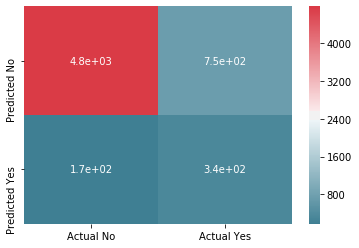

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
grd = GradientBoostingClassifier()
random_grid = {'n_estimators': [50,100], 
                'max_depth': [3,4], 
               "learning_rate":[0.098,1,1.02],
                'min_samples_split': [2,3], 
                'min_samples_leaf': [1,2]} 
grd_random = RandomizedSearchCV(estimator = grd, 
                               param_distributions = random_grid, 
                               n_iter = 20, cv = kfold, verbose=2, 
                               random_state=42, n_jobs = -1) 
grd_random.fit(x_train, y_train) 
print("best hyperparameters for Gradient Boosting are:")
pprint(grd_random.best_params_)
print("")
grd_best_random = grd_random.best_estimator_ 
predictions_grd = grd_best_random.predict(x_test) 
CM_grd_reg=confusion_matrix(y_test, predictions_grd)
df_cm = pd.DataFrame(CM_grd_reg, index = ["Predicted No","Predicted Yes"],
                  columns = ["Actual No","Actual Yes"])
print(classification_report(y_test, predictions_grd,target_names=["no","yes"]))
plt.figure()
sns.heatmap(df_cm,cmap=cmap, annot=True)
#AUC
probs_grd = grd_random.predict_proba(x_test)
preds_grd = probs_grd[:,1]
fprgrd, tprgrd, thresholdgrd = metrics.roc_curve(y_test, preds_grd)
roc_aucgrd = metrics.auc(fprgrd, tprgrd)

**AUC Curves**

--- 4.38 minutes ---


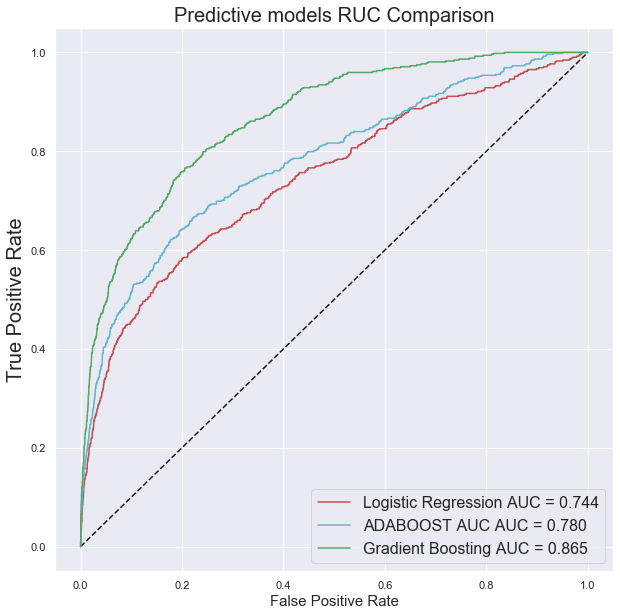

In [54]:
sns.set()
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1],'k--')
plt.title('Predictive models RUC Comparison',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=15)
plt.plot(fprLR, tprLR,'-r', label = 'Logistic Regression AUC = %0.3f' % roc_aucLR)
plt.plot(fprADA, tprADA,'-c', label = 'ADABOOST AUC AUC = %0.3f' % roc_aucADA)
plt.plot(fprgrd, tprgrd,'-g', label = 'Gradient Boosting AUC = %0.3f' % roc_aucgrd)
plt.legend(loc = 'lower right', prop={'size': 16})
print("--- %s minutes ---" % (round(time.time()/60 - start_time/60,2)))

**Conclusion**

-Best hyperparameters for each method  were chosen by the RandomizedSearchCV - the parameters of the estimator that were used to apply these methods are optimized by cross-validated search over parameter settings.

-We chose the best model according to recall, percision and F1 score measurements.

# Our best model by Recall, precision, F1 score and AUC is Gradient Boosting Optimized